In [6]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [7]:
!wget -nc https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

File ‘airline-passengers.csv’ already there; not retrieving.



In [9]:
dataframe = pandas.read_csv('airline-passengers.csv', usecols=[1])
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset[:10]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.]], dtype=float32)

In [10]:
# LSTM sensitive to scale, especially with sigmoid and tanh functions.
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset[:10]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753]], dtype=float32)

In [11]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print("train_size: ", train_size)
print("test_size: ", test_size)
print("combined: ", train_size+test_size)


train_size:  96
test_size:  48
combined:  144


In [12]:
train[:10]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753]], dtype=float32)

In [13]:
test[:10]

array([[0.4073359 ],
       [0.3803089 ],
       [0.48648646],
       [0.47104248],
       [0.484556  ],
       [0.6138996 ],
       [0.6969112 ],
       [0.70077217],
       [0.57915056],
       [0.46911195]], dtype=float32)

In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    """
    Function that creates a new dataset
    Parameters:
        dataset (numpy array): numpy array that is to be converted to a dataset/
        look_back (int): number of previous steps to use as input variables to predict the next time period
        
    Returns:
        dataX (numpy array): number of passenders at a given time (t)
        dataY (numpy array): number of passengers at the next time (t+1)
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [15]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [16]:
trainX[:5]

array([[0.01544401, 0.02702703, 0.05405405],
       [0.02702703, 0.05405405, 0.04826255],
       [0.05405405, 0.04826255, 0.03281853],
       [0.04826255, 0.03281853, 0.05984557],
       [0.03281853, 0.05984557, 0.08494207]], dtype=float32)

In [17]:
trainY[:5]

array([0.04826255, 0.03281853, 0.05984557, 0.08494207, 0.08494207],
      dtype=float32)

In [18]:
# LSTM network expects input data (X) to be provided with a specific array structure in the form of [samples, timestep, features]
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
trainX[:5]

array([[[0.01544401, 0.02702703, 0.05405405]],

       [[0.02702703, 0.05405405, 0.04826255]],

       [[0.05405405, 0.04826255, 0.03281853]],

       [[0.04826255, 0.03281853, 0.05984557]],

       [[0.03281853, 0.05984557, 0.08494207]]], dtype=float32)

In [20]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1, validation_split=0.2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 73 samples, validate on 19 samples
Epoch 1/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0113 - val_loss: 0.0386
Epoch 2/100
73/73 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0215
Epoch 3/100
73/73 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0195
Epoch 4/100
73/73 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0163
Epoch 5/100
73/73 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0144
Epoch 6/100
73/73 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0139
Epoch 7/100
73/73 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0119
Epoch 8/100
73/73 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0112
Epoch 9/100
73/73 [==============================] - 0s 2ms/step - loss: 0.0024 - 

In [21]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


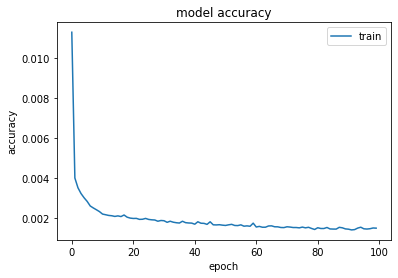

In [22]:
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

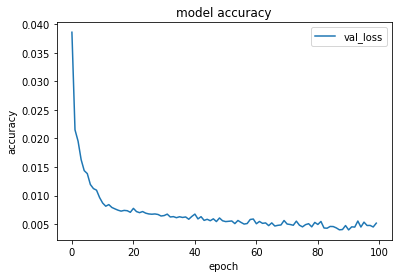

In [23]:
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_loss'], loc='upper right')
plt.show()

In [24]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [25]:
trainPredict[:5].ravel()

array([0.05863129, 0.05722386, 0.04272173, 0.06260049, 0.08761398],
      dtype=float32)

In [26]:
trainX[:5].ravel()

array([0.01544401, 0.02702703, 0.05405405, 0.02702703, 0.05405405,
       0.04826255, 0.05405405, 0.04826255, 0.03281853, 0.04826255,
       0.03281853, 0.05984557, 0.03281853, 0.05984557, 0.08494207],
      dtype=float32)

In [27]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [28]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 24.31 RMSE
Test Score: 64.45 RMSE


In [29]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


In [30]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


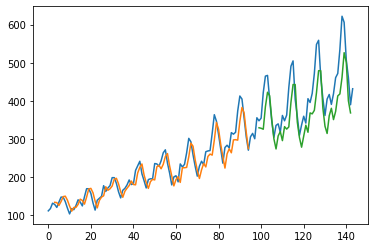

In [31]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()